In [127]:
# Load pyspark
import findspark

findspark.init()

#import pyspark
import os
import shutil
from pyspark import SparkContext
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.window import Window
from pyspark.ml.feature import Bucketizer

import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

spark = SparkSession.builder.appName("dengue").getOrCreate()

### Chargement des données

In [128]:
path_to_data = "data/"

df_features = spark.read.csv(path_to_data + "dengue_features_train.csv",
                             header=True)
df_labels = spark.read.csv(path_to_data + "dengue_labels_train.csv",
                           header=True)

#join df_features + df_labels
df_train = df_features.join(df_labels, ['city', 'year', 'weekofyear'])

print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

df_train = (1456, 25)


### Nettoyage des données

In [129]:
def clean_df(df_train):

    # The 2 columns 'precipitation_amt_mm' and 'reanalysis_sat_precip_amt_mm' are the same
    # we drop 'precipitation_amt_mm'
    df_train = df_train.drop('precipitation_amt_mm')

    # recast 'week_start_date' as a date. Nice to have for plotting or time series analysis
    df_train = df_train.withColumn('week_start_date', F.to_date('week_start_date', 'yyyy-MM-dd'))

    # recast 'year' and 'weekofyear' to integer
    df_train = df_train \
        .withColumn('year', df_train['year'].cast('int')) \
        .withColumn('weekofyear', df_train['weekofyear'].cast('int'))

    # cast columns to float
    for col_name in df_train.columns[4:-1]:
        df_train = df_train.withColumn(col_name, df_train[col_name].cast('float'))

    df_train.printSchema()
    return df_train

# cast column total_cases as integer
df_train = df_train.withColumn('total_cases', df_train['total_cases'].cast('int'))
df_train = clean_df(df_train)

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_air_temp_k: float (nullable = true)
 |-- reanalysis_avg_temp_k: float (nullable = true)
 |-- reanalysis_dew_point_temp_k: float (nullable = true)
 |-- reanalysis_max_air_temp_k: float (nullable = true)
 |-- reanalysis_min_air_temp_k: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- reanalysis_tdtr_k: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 

In [130]:
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

# identify null value
# ===================
for col_name in df_train.columns:
    print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))

df_train = (1456, 24)
city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 194
ndvi_nw => 52
ndvi_se => 22
ndvi_sw => 22
reanalysis_air_temp_k => 10
reanalysis_avg_temp_k => 10
reanalysis_dew_point_temp_k => 10
reanalysis_max_air_temp_k => 10
reanalysis_min_air_temp_k => 10
reanalysis_precip_amt_kg_per_m2 => 10
reanalysis_relative_humidity_percent => 10
reanalysis_sat_precip_amt_mm => 13
reanalysis_specific_humidity_g_per_kg => 10
reanalysis_tdtr_k => 10
station_avg_temp_c => 43
station_diur_temp_rng_c => 43
station_max_temp_c => 20
station_min_temp_c => 14
station_precip_mm => 22
total_cases => 0


In [131]:
def fill_null(df_train): # Fill Null value with previous value
    w = Window().partitionBy().orderBy(F.col('week_start_date'))

    for col_name in df_train.columns[4:-1]:
        df_train = df_train.withColumn(col_name, F.last(col_name, True).over(w))
    
    # last column also relevant for the test bench
    df_train = df_train.withColumn(df_train.columns[-1], F.last(df_train.columns[-1], True).over(w))
    
    # identify null value
    for col_name in df_train.columns:
        print("{} => {}".format(col_name,
                            df_train.filter(F.isnull(df_train[col_name])).count()))
    return df_train
        
df_train = fill_null(df_train)

city => 0
year => 0
weekofyear => 0
week_start_date => 0
ndvi_ne => 0
ndvi_nw => 0
ndvi_se => 0
ndvi_sw => 0
reanalysis_air_temp_k => 0
reanalysis_avg_temp_k => 0
reanalysis_dew_point_temp_k => 0
reanalysis_max_air_temp_k => 0
reanalysis_min_air_temp_k => 0
reanalysis_precip_amt_kg_per_m2 => 0
reanalysis_relative_humidity_percent => 0
reanalysis_sat_precip_amt_mm => 0
reanalysis_specific_humidity_g_per_kg => 0
reanalysis_tdtr_k => 0
station_avg_temp_c => 0
station_diur_temp_rng_c => 0
station_max_temp_c => 0
station_min_temp_c => 0
station_precip_mm => 0
total_cases => 0


### Plot

In [132]:
df_train_sj = df_train.filter(df_train.city == 'sj')
min_date_sj, max_date_sj = df_train_sj.select(F.min("week_start_date"), F.max("week_start_date")).first()

print("San Juan data:")
print("df_train_sj = ({}, {})".format(df_train_sj.count(), len(df_train_sj.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_sj, max_date_sj))

df_train_iq = df_train.filter(df_train.city == 'iq')
min_date_iq, max_date_iq = df_train_iq.select(F.min("week_start_date"), F.max("week_start_date")).first()

print("Iquitos data:")
print("df_train_iq = ({}, {})".format(df_train_iq.count(), len(df_train_iq.columns)))
print("\tdate_start = {} / date_stop = {}".format(min_date_iq, max_date_iq))

San Juan data:
df_train_sj = (936, 24)
	date_start = 1990-04-30 / date_stop = 2008-04-22
Iquitos data:
df_train_iq = (520, 24)
	date_start = 2000-07-01 / date_stop = 2010-06-25


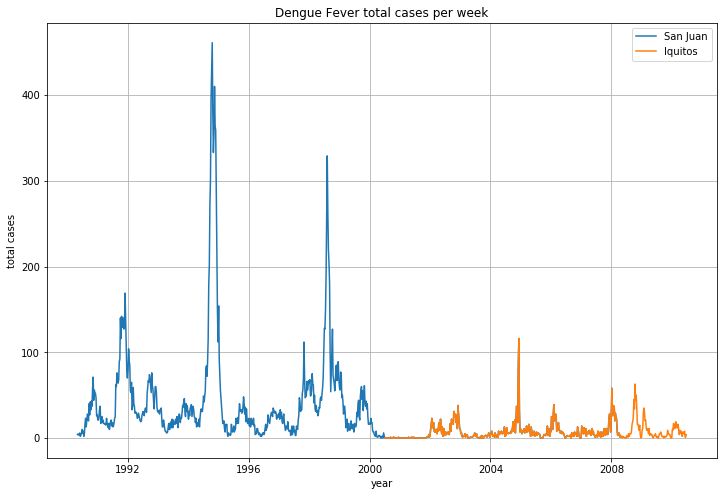

In [133]:
pd_train_sj = df_train_sj.toPandas()
pd_train_iq = df_train_iq.toPandas()

# Total cases per city
fig = plt.figure(figsize=(12, 8))

plt.grid()
plt.title('Dengue Fever total cases per week')

plt.xlabel('year')
plt.ylabel('total cases')
plt.xticks()
plt.yticks()

plt.plot(pd_train_sj['week_start_date'], pd_train_sj['total_cases'], label='San Juan')
plt.plot(pd_train_iq['week_start_date'], pd_train_iq['total_cases'], label='Iquitos')

plt.legend()

fig.savefig("figs/01-fig_01.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Build new columns

In [134]:
def convert_units(df_train):# convert temperature from kelvin to degree

    df_train = df_train \
        .withColumn('reanalysis_air_temp_c', df_train['reanalysis_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_avg_temp_c', df_train['reanalysis_avg_temp_k'] - 273.15) \
        .withColumn('reanalysis_dew_point_temp_c', df_train['reanalysis_dew_point_temp_k'] - 273.15) \
        .withColumn('reanalysis_max_air_temp_c', df_train['reanalysis_max_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_min_air_temp_c', df_train['reanalysis_min_air_temp_k'] - 273.15) \
        .withColumn('reanalysis_tdtr_c', df_train['reanalysis_tdtr_k'] - 273.15)

    df_train = df_train \
        .drop('reanalysis_air_temp_k') \
        .drop('reanalysis_avg_temp_k') \
        .drop('reanalysis_dew_point_temp_k') \
        .drop('reanalysis_max_air_temp_k') \
        .drop('reanalysis_min_air_temp_k') \
        .drop('reanalysis_tdtr_k')
    
    return df_train

df_train = convert_units(df_train)

#### Végétation

NDVI Normalized difference vegetation index (NDVI) indique l'indice de végétation :
- en dessous de -0.1 il s'agit probablement d'eau
- entre -0.1 et 0.1 urbanisé ou pierre ou minéral ou terre nue
- entre 0.1 et 0.4 végétation peu dense
- au dessus de 0.4 végétation dense


(à noter que les seuils ne sont pas toujours très bien définis...)

In [135]:
def bucketize(df):
    splits = [-float("inf"), -0.1, 0.1, 0.4, float("inf")]

    bucketizer_ne = Bucketizer(splits=splits, inputCol="ndvi_ne", outputCol="bucket_ne")
    bucketizer_nw = Bucketizer(splits=splits, inputCol="ndvi_nw", outputCol="bucket_nw")
    bucketizer_sw = Bucketizer(splits=splits, inputCol="ndvi_sw", outputCol="bucket_sw")
    bucketizer_se = Bucketizer(splits=splits, inputCol="ndvi_se", outputCol="bucket_se")
    
    # Transform original data into its bucket index.
    bucketedData = bucketizer_ne.transform(df)
    bucketedData = bucketizer_nw.transform(bucketedData)
    bucketedData = bucketizer_sw.transform(bucketedData)
    bucketedData = bucketizer_se.transform(bucketedData)
    
    return bucketedData

df_train = bucketize(df_train)

In [136]:
def compute_lags(df_train):
    # build a window
    w = Window().partitionBy().orderBy(F.col('week_start_date'))

    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))

    # add new columns with different lags
    df_train = df_train \
        .withColumn('station_avg_temp_1_c', F.lag('station_avg_temp_c', count=1).over(w)) \
        .withColumn('station_avg_temp_2_c', F.lag('station_avg_temp_c', count=2).over(w)) \
        .withColumn('station_avg_temp_3_c', F.lag('station_avg_temp_c', count=3).over(w)) \
        .withColumn('station_avg_temp_4_c', F.lag('station_avg_temp_c', count=4).over(w)) \
        .withColumn('station_precip_1_mm', F.lag('station_precip_mm', count=1).over(w)) \
        .withColumn('station_precip_2_mm', F.lag('station_precip_mm', count=2).over(w)) \
        .withColumn('station_precip_3_mm', F.lag('station_precip_mm', count=3).over(w)) \
        .withColumn('station_precip_4_mm', F.lag('station_precip_mm', count=4).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_1_mm', F.lag('reanalysis_sat_precip_amt_mm', count=1).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_2_mm', F.lag('reanalysis_sat_precip_amt_mm', count=2).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_3_mm', F.lag('reanalysis_sat_precip_amt_mm', count=3).over(w)) \
        .withColumn('reanalysis_sat_precip_amt_4_mm', F.lag('reanalysis_sat_precip_amt_mm', count=4).over(w))

    df_train = df_train \
        .withColumn('d_station_avg_temp_1_c', df_train['station_avg_temp_1_c'] - df_train['station_avg_temp_c']) \
        .withColumn('d_station_avg_temp_2_c', df_train['station_avg_temp_2_c'] - df_train['station_avg_temp_c']) \
        .withColumn('d_station_avg_temp_3_c', df_train['station_avg_temp_3_c'] - df_train['station_avg_temp_c']) \
        .withColumn('d_station_avg_temp_4_c', df_train['station_avg_temp_4_c'] - df_train['station_avg_temp_c']) \
        .withColumn('d_station_precip_1_mm', df_train['station_precip_1_mm'] - df_train['station_precip_mm']) \
        .withColumn('d_station_precip_2_mm', df_train['station_precip_2_mm'] - df_train['station_precip_mm']) \
        .withColumn('d_station_precip_3_mm', df_train['station_precip_3_mm'] - df_train['station_precip_mm']) \
        .withColumn('d_station_precip_4_mm', df_train['station_precip_4_mm'] - df_train['station_precip_mm']) \
        .withColumn('d_reanalysis_sat_precip_amt_1_mm', df_train['reanalysis_sat_precip_amt_1_mm'] - df_train['reanalysis_sat_precip_amt_mm']) \
        .withColumn('d_reanalysis_sat_precip_amt_2_mm', df_train['reanalysis_sat_precip_amt_2_mm'] - df_train['reanalysis_sat_precip_amt_mm']) \
        .withColumn('d_reanalysis_sat_precip_amt_3_mm', df_train['reanalysis_sat_precip_amt_3_mm'] - df_train['reanalysis_sat_precip_amt_mm']) \
        .withColumn('d_reanalysis_sat_precip_amt_4_mm', df_train['reanalysis_sat_precip_amt_4_mm'] - df_train['reanalysis_sat_precip_amt_mm'])
 
    print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
    return df_train

df_train = compute_lags(df_train)
# we drop the four first rows 
df_train = df_train.dropna()
print("df_train = ({}, {})".format(df_train.count(), len(df_train.columns)))
#df_train.show()

df_train = (1456, 28)
df_train = (1456, 52)
df_train = (1452, 52)


In [137]:
# save preprocessed dataframe
path_to_dir = "data/preprocessed"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)
    
df_train.write.parquet(path_to_dir)

### Preprocess benchmark data

In [138]:
# chargement des données
path_to_data = "data/"

df_bench = spark.read.csv(path_to_data + "dengue_features_test.csv",
                             header=True)

print("df_bench = ({}, {})".format(df_bench.count(), len(df_bench.columns)))

df_bench = (416, 24)


In [139]:
df_bench = clean_df(df_bench)
df_bench = df_bench.withColumn("station_precip_mm", df_bench["station_precip_mm"].cast('float'))
df_bench = fill_null(df_bench)
df_bench = convert_units(df_bench)
df_bench = bucketize(df_bench)
df_bench = compute_lags(df_bench)


root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = true)
 |-- ndvi_nw: float (nullable = true)
 |-- ndvi_se: float (nullable = true)
 |-- ndvi_sw: float (nullable = true)
 |-- reanalysis_air_temp_k: float (nullable = true)
 |-- reanalysis_avg_temp_k: float (nullable = true)
 |-- reanalysis_dew_point_temp_k: float (nullable = true)
 |-- reanalysis_max_air_temp_k: float (nullable = true)
 |-- reanalysis_min_air_temp_k: float (nullable = true)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = true)
 |-- reanalysis_relative_humidity_percent: float (nullable = true)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = true)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = true)
 |-- reanalysis_tdtr_k: float (nullable = true)
 |-- station_avg_temp_c: float (nullable = true)
 |-- station_diur_temp_rng_c: float (nullable = true)
 

In [140]:
df_bench = df_bench.na.fill(0.)

In [141]:
# save preprocessed dataframe
path_to_dir = "data/preprocessed_bench"

if os.path.exists(path_to_dir) and os.path.isdir(path_to_dir):
    shutil.rmtree(path_to_dir)
    
df_bench.write.parquet(path_to_dir)

In [142]:
df_bench.printSchema()

root
 |-- city: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekofyear: integer (nullable = true)
 |-- week_start_date: date (nullable = true)
 |-- ndvi_ne: float (nullable = false)
 |-- ndvi_nw: float (nullable = false)
 |-- ndvi_se: float (nullable = false)
 |-- ndvi_sw: float (nullable = false)
 |-- reanalysis_precip_amt_kg_per_m2: float (nullable = false)
 |-- reanalysis_relative_humidity_percent: float (nullable = false)
 |-- reanalysis_sat_precip_amt_mm: float (nullable = false)
 |-- reanalysis_specific_humidity_g_per_kg: float (nullable = false)
 |-- station_avg_temp_c: float (nullable = false)
 |-- station_diur_temp_rng_c: float (nullable = false)
 |-- station_max_temp_c: float (nullable = false)
 |-- station_min_temp_c: float (nullable = false)
 |-- station_precip_mm: float (nullable = false)
 |-- reanalysis_air_temp_c: double (nullable = false)
 |-- reanalysis_avg_temp_c: double (nullable = false)
 |-- reanalysis_dew_point_temp_c: double (nullable = fal